## Bibliometric Analysis of Smart Meter Analysis 

**Abstract**
Bibliometric analysis of Smart meter data to examine publication trends, topical structure, collaboration networks, and citation dynamics. 

**Project Notes & How to Reproduce**

1. Place raw exports in `data/raw/` (CSV/TSV/JSON).
2. Set `CONFIG["data"]["input_files"]`.
3. Run cells in order: ingest → clean → analyze → visualize.
4. Outputs saved to `data/interim/`, `data/processed/`, and `figures/`.

**Ethics & Usage:** Respect data licensing terms. Do not attempt de-anonymization. Cite original data sources.


In [4]:
# -----------------------------------------------------------------------------
# setup & environment check
# -----------------------------------------------------------------------------

# todo: issue #1 add cli args for paths and thresholds.
# todo: issue #2 add unit tests for data loader column picking.
# todo: issue #3 parametrize model choice via config file.

# seed any randomness and log it.
# # we seed numpy even though we do not rely on randomness much here.
import numpy as np

np.random.seed(0)  # keep runs consistent across machines.

# confirm python + deps and snapshot a lightweight requirements file.
# # this makes results reproducible later.
import sys
from importlib import metadata as importlib_metadata
from pathlib import Path


def _write_requirements(out_dir: str) -> None:
    """Write a minimal requirements.txt based on currently imported libs.

    Args:
        out_dir: Directory to write requirements.txt into.

    Returns:
        None.

    Raises:
        OSError: If the output directory cannot be created or written.
    """
    # target path for reproducibility artifacts.
    p = Path(out_dir)
    p.mkdir(parents=True, exist_ok=True)

    # collect pinned versions for key deps we use here.
    # # keep the list short to avoid overfreezing unrelated libs.
    wanted = [
        "pandas",
        "numpy",
        "matplotlib",
        "transformers",
        "torch",  # transformers often pulls torch; pin if present.
        "scikit-learn",  # optional, but common in analytics stacks.
    ]
    lines = []
    for name in wanted:
        try:
            ver = importlib_metadata.version(name)
            lines.append(f"{name}=={ver}")
        except importlib_metadata.PackageNotFoundError:
            # skip silently if not installed.
            pass

    # always include a python version marker at the top.
    header = [
        f"# python=={sys.version.split()[0]}",
        "# generated by script for reproducibility.",
        "# feel free to add/trim as your env evolves.",
        "",
    ]
    (p / "requirements.txt").write_text("\n".join(header + lines), encoding="utf-8")


def _log_env() -> None:
    """Print a short environment banner for debugging.

    Returns:
        None.
    """
    print(f"[env] python: {sys.version.split()[0]}")
    for name in ["pandas", "numpy", "matplotlib", "transformers"]:
        try:
            ver = importlib_metadata.version(name)
            print(f"[env] {name}: {ver}")
        except importlib_metadata.PackageNotFoundError:
            print(f"[env] {name}: not installed")



In [5]:
# -----------------------------------------------------------------------------
# style config — use seaborn-like theme with bigger fonts
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")   # base style, then we sprinkle ✨

plt.rcParams.update({
    "figure.dpi": 130,              # crisp but not too heavy
    "axes.titlesize": 16,           # titles a lil bolder 💅
    "axes.labelsize": 13,           # labels comfy readable
    "xtick.labelsize": 11,          # smol ticks but clear
    "ytick.labelsize": 11,
    "font.family": "sans-serif",    # smooth modern font
    "font.sans-serif": ["Comic Neue", "Arial Rounded MT Bold", "DejaVu Sans"],

    # pastel axis lines 🎀
    "axes.edgecolor": "#C8B6FF",    # soft lavender
    "axes.linewidth": 1.2,          # a lil chunkier

    # gridlines = soft candy stripes 🍬
    "grid.color": "#FFD6E8",        # pinky grid
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,

    # make background dreamy ☁️
    "axes.facecolor": "#FFF9FF",    # subtle cream
    "figure.facecolor": "#FFFDFE",
})



In [6]:
# -----------------------------------------------------------------------------
# paths & knobs 
# -----------------------------------------------------------------------------

# # absolute paths are fine locally; consider cli args for portability.
INPUT_CSV = "/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/code/Bibliometric_Analysis.csv"
OUT_DIR = "/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/code/out_semantic"

# # model & runtime parameters.
THRESHOLD = 0.5  # probability cutoff to assign a label
DEVICE = -1  # -1 = cpu, 0 = first gpu
BATCH_SIZE = 8
MAX_CHARS = 4000  # truncate each doc before sending to model


In [7]:
# -----------------------------------------------------------------------------
# imports
# -----------------------------------------------------------------------------

# # keep imports grouped and minimal.
from __future__ import annotations

import re
from dataclasses import dataclass, field
from typing import Dict, Iterable, List, Optional, Tuple

import pandas as pd
from transformers import pipeline



In [8]:
# -----------------------------------------------------------------------------
# configuration
# -----------------------------------------------------------------------------

@dataclass
class CategoryConfig:
    """Label set + descriptions to guide the zero-shot model.

    Attributes:
        labels: Mapping from category to short guidance description.
        hypothesis_template: Template for zero-shot entailment prompts.
        lack_labels: Two labels to probe limitation mention detection.
        lack_hypothesis: Template for limitation probing prompt.
    """

    labels: Dict[str, str] = field(
        default_factory=lambda: {
            # # keep categories mutually comprehensible rather than mutually exclusive.
            "unsupervised learning": "clustering, dimensionality reduction, anomaly detection, no labels",
            "supervised learning": "classification or regression with labeled data",
            "reinforcement learning": "agents learning actions via rewards, rl, q-learning",
            "semi/self-supervised": "semi-supervised, self-supervised, contrastive learning",
            "time series / forecasting": "temporal forecasting, time-series models, arima, lstm",
            "deep learning": "neural networks such as cnn, rnn, transformers",
            "anomaly / novelty detection": "detecting anomalies or outliers or rare events",
        }
    )
    hypothesis_template: str = "This paper is about {}."
    lack_labels: List[str] = field(
        default_factory=lambda: [
            "mentions limitations or a lack of data/resources/labels",
            "does not mention limitations or lack",
        ]
    )
    lack_hypothesis: str = "This paper explicitly mentions {}."  # keep consistent formatting.



In [9]:
# -----------------------------------------------------------------------------
# data utilities
# -----------------------------------------------------------------------------

class DataLoader:
    """Load a csv and build a single text field per record.

    Args:
        path: Path to the csv file.
        max_chars: Max characters to keep per combined text cell.

    Attributes:
        path: Path provided at init.
        max_chars: Truncation limit for text.
        df: Loaded dataframe after `load()`.

    Raises:
        RuntimeError: If the csv cannot be read with common encodings.
    """

    def __init__(self, path: str, max_chars: int = 4000) -> None:
        self.path = path
        self.max_chars = max_chars
        self.df: pd.DataFrame = pd.DataFrame()

    @staticmethod
    def _normcol(name: str) -> str:
        """Normalize a column name to a simple snake-like token."""
        # # avoid brittle matching on vendor-specific headers.
        return re.sub(r"[^a-z0-9]+", " ", name.strip().lower()).strip()

    @staticmethod
    def _safe(x: object) -> str:
        """Convert possible nan to empty string."""
        return "" if pd.isna(x) else str(x)

    def load(self) -> pd.DataFrame:
        """Read the csv and construct a `_text` column.

        tries utf-8, utf-8-sig, iso-8859-1 in that order.
        attempts to join likely title/abstract/keywords columns into one text.

        Returns:
            A dataframe with an added `_text` column containing lowercased text.

        Raises:
            RuntimeError: If the csv cannot be read using the known encodings.
        """
        # try a few encodings commonly seen in exported bibliometrics files.
        encs = ["utf-8", "utf-8-sig", "ISO-8859-1"]
        last_exc: Optional[Exception] = None
        for enc in encs:
            try:
                self.df = pd.read_csv(self.path, encoding=enc)
                break
            except Exception as exc:
                last_exc = exc
        if self.df.empty:
            raise RuntimeError(f"could not read csv with common encodings: {last_exc}")

        # normalize column names for robust picking.
        self.df.columns = [self._normcol(c) for c in self.df.columns]
        cols = set(self.df.columns)

        # helper to pick the first present candidate column.
        def pick(cands: Iterable[str]) -> Optional[str]:
            for c in cands:
                if c in cols:
                    return c
            return None

        title = pick(["title", "document title", "ti"])
        abstract = pick(["abstract", "ab", "description", "summary"])
        keywords = pick(["author keywords", "keywords", "index keywords", "de", "id", "keywords plus"])

        # build the text field with best-effort concatenation.
        parts: List[pd.Series] = []
        if title:
            parts.append(self.df[title].map(self._safe))
        if abstract:
            parts.append(self.df[abstract].map(self._safe))
        if keywords:
            parts.append(self.df[keywords].map(self._safe))

        if parts:
            text = pd.Series([". ".join(p) for p in zip(*parts)]).str.lower()
        else:
            # fallback: just join all columns if we cannot pick standard ones.
            text = self.df.astype(str).agg(" ".join, axis=1).str.lower()

        # truncate long texts to keep inference lighter.
        self.df["_text"] = text.map(lambda s: s[: self.max_chars] if isinstance(s, str) else "")
        return self.df



In [10]:
# -----------------------------------------------------------------------------
# zero-shot model
# -----------------------------------------------------------------------------

class ZeroShotCategorizer:
    """Wrap a hugging face zero-shot classifier for multi-label tagging.

    Args:
        config: CategoryConfig with labels and prompt templates.
        threshold: Score threshold to mark a label present.
        device: Transformers device index (-1 cpu, >=0 specific gpu).
        model_name: HF model id for zero-shot (mnli) classification.
        batch_size: Batch size for the pipeline.

    Attributes:
        pipe: Transformers pipeline instance.
        batch_size: Batch size used for inference.
        config: Stored CategoryConfig.
        threshold: Stored score threshold.
    """

    def __init__(
        self,
        config: CategoryConfig,
        threshold: float = 0.5,
        device: Optional[int] = None,
        model_name: str = "facebook/bart-large-mnli",
        batch_size: int = 8,
    ) -> None:
        self.config = config
        self.threshold = float(threshold)
        if device is None:
            # default to cpu to reduce surprise oom on shared machines.
            device = -1
        # build the hf pipeline lazily with chosen device.
        self.pipe = pipeline(
            "zero-shot-classification",
            model=model_name,
            device=device,
        )
        self.batch_size = int(batch_size)

    @staticmethod
    def _chunks(items: List[str], size: int) -> Iterable[List[str]]:
        """Yield successive `size`-sized chunks from items."""
        for i in range(0, len(items), size):
            yield items[i : i + size]

    def classify(self, texts: List[str]) -> List[Dict[str, float]]:
        """Return label→score dicts (0..1) per text using multi-label.

        Args:
            texts: List of input texts to classify.

        Returns:
            A list of dicts mapping category label to score for each text.
        """
        candidate_labels = list(self.config.labels.keys())
        results: List[Dict[str, float]] = []
        for batch in self._chunks(texts, self.batch_size):
            out = self.pipe(
                batch,
                candidate_labels=candidate_labels,
                hypothesis_template=self.config.hypothesis_template,
                multi_label=True,
            )
            # pipeline returns dict for single-item batches; normalize to list.
            if isinstance(out, dict):
                out = [out]
            for res in out:
                scores = {lab: 0.0 for lab in candidate_labels}
                for lab, score in zip(res["labels"], res["scores"]):
                    scores[lab] = float(score)
                results.append(scores)
        return results

    def classify_lack(self, texts: List[str]) -> List[float]:
        """Score (0..1) for whether a paper mentions limitations/lack.

        Args:
            texts: List of input texts.

        Returns:
            A list of floats with the score for the 'lack' label.
        """
        out_scores: List[float] = []
        for batch in self._chunks(texts, self.batch_size):
            out = self.pipe(
                batch,
                candidate_labels=self.config.lack_labels,
                hypothesis_template=self.config.lack_hypothesis,
                multi_label=True,
            )
            if isinstance(out, dict):
                out = [out]
            for res in out:
                score_map = {lab: sc for lab, sc in zip(res["labels"], res["scores"])}
                out_scores.append(float(score_map.get(self.config.lack_labels[0], 0.0)))
        return out_scores



In [11]:
# -----------------------------------------------------------------------------
# visuals
# -----------------------------------------------------------------------------

class Visualizer:
    """Matplotlib charts saved to disk and displayed inline.

    Args:
        out_dir: Directory where figures may be saved (and reqs file too).

    Attributes:
        out_dir: Output directory path.
    """

    def __init__(self, out_dir: str) -> None:
        self.out_dir = out_dir
        Path(out_dir).mkdir(parents=True, exist_ok=True)

    def category_bars(self, share_df: pd.DataFrame) -> None:
        """Horizontal bar chart showing % of papers per category.

        Args:
            share_df: Dataframe with columns [category, percent, ...].

        Returns:
            None.
        """
        # sort so the smallest bars start at the bottom for readability.
        plot = share_df.sort_values("percent", ascending=True)
        fig, ax = plt.subplots(figsize=(8, 6))
        bars = ax.barh(plot["category"], plot["percent"], color="#4C72B0", alpha=0.9)
        ax.set_xlabel("percent of papers")
        ax.set_title("share of papers by category (zero-shot)", weight="bold")
        # add value labels inline for quick scanning.
        for bar, val in zip(bars, plot["percent"]):
            ax.text(
                val + 0.5,
                bar.get_y() + bar.get_height() / 2,
                f"{val:.1f}%",
                va="center",
                ha="left",
                fontsize=9,
            )
        fig.tight_layout()
        plt.show()

    def lack_bar(self, lack_percent: float) -> None:
        """Single-line barless callout for 'lack' mentions.

        Args:
            lack_percent: Percentage of papers mentioning limitations/lack.

        Returns:
            None.
        """
        fig, ax = plt.subplots(figsize=(7, 1.5))
        ax.text(
            0.5,
            0.5,
            f"'lack/limitations' mentions: {lack_percent:.1f}% of papers",
            ha="center",
            va="center",
            size=12,
            weight="bold",
            color="#C44E52",
        )
        ax.axis("off")
        fig.tight_layout()
        plt.show()



In [12]:
# -----------------------------------------------------------------------------
# pipeline
# -----------------------------------------------------------------------------

class Runner:
    """End-to-end: load → model classify → aggregate → export → visualize.

    Args:
        input_csv: Path to input csv.
        out_dir: Output directory for figures and artifacts.
        threshold: Score threshold for label presence decisions.
        config: Optional CategoryConfig override.
        device: Transformers device index (-1 cpu).
        batch_size: Inference batch size for the pipeline.
        max_chars: Truncation length for combined text field.

    Attributes:
        loader: DataLoader instance.
        model: ZeroShotCategorizer instance.
        viz: Visualizer instance.
        config: CategoryConfig.
        threshold: Decision threshold.
    """

    def __init__(
        self,
        input_csv: str,
        out_dir: str,
        threshold: float,
        config: Optional[CategoryConfig] = None,
        device: Optional[int] = None,
        batch_size: int = 8,
        max_chars: int = 4000,
    ) -> None:
        self.input_csv = input_csv
        self.out_dir = out_dir
        self.threshold = threshold
        self.config = config or CategoryConfig()
        self.loader = DataLoader(input_csv, max_chars=max_chars)
        self.model = ZeroShotCategorizer(
            self.config, threshold=threshold, device=device, batch_size=batch_size
        )
        self.viz = Visualizer(out_dir)

    @staticmethod
    def _pct(x: float) -> str:
        """Human-friendly percentage with compact formatting."""
        return f"{x:.0f}%" if x >= 10 else f"{x:.1f}%"

    def run(self) -> Dict[str, object]:
        """Execute the full pipeline and display outputs.

        Returns:
            Dict with keys:
                - n_papers (int)
                - category_share (pd.DataFrame)
                - lack_percent (float)
                - sample_statements (List[str])
        """
        # load and prepare input data.
        df = self.loader.load()
        texts = df["_text"].fillna("").tolist()
        n_docs = len(texts)

        # ensure output dir exists and record env for reproducibility.
        Path(self.out_dir).mkdir(parents=True, exist_ok=True)
        _write_requirements(self.out_dir)

        # ---- categorize (multi-label) ----
        print("classifying papers by topic...")
        cat_scores = self.model.classify(texts)
        cat_labels = list(self.config.labels.keys())

        # convert scores to boolean presence using threshold.
        cat_present = [
            {lab: (scores.get(lab, 0.0) >= self.threshold) for lab in cat_labels} for scores in cat_scores
        ]

        # aggregate counts and compute shares.
        cat_counts = {lab: int(sum(doc[lab] for doc in cat_present)) for lab in cat_labels}
        cat_share = (
            pd.DataFrame(
                [
                    {
                        "category": lab,
                        "n_papers": cnt,
                        "percent": round((100.0 * cnt / n_docs) if n_docs else 0.0, 1),
                        "desc": self.config.labels[lab],
                    }
                    for lab, cnt in cat_counts.items()
                ]
            ).sort_values("percent", ascending=False)
        )

        # ---- lack/limitations ----
        print("checking for limitation mentions...")
        lack_scores = self.model.classify_lack(texts)
        lack_flags = [s >= self.threshold for s in lack_scores]
        lack_percent = round(100.0 * sum(lack_flags) / n_docs, 1) if n_docs else 0.0

        # ---- visuals ----
        print("\nresults:")
        self.viz.category_bars(cat_share)
        self.viz.lack_bar(lack_percent)

        # show key tables inline when used in a notebook.
        try:
            from IPython.display import display  # local import to avoid hard dep.
            print("\ncategory share (zero-shot):")
            display(cat_share)
        except Exception:
            # # printing a compact head if not in ipython.
            print("\ncategory share (zero-shot):")
            print(cat_share.to_string(index=False))

        # craft a few short statements as narrative takeaways.
        statements = [
            f"{self._pct(float(r['percent']))} of papers dealt with {r['category']}."
            for _, r in cat_share.iterrows()
        ]
        statements.append(
            f"{self._pct(lack_percent)} of papers explicitly mentioned limitations or lack of resources."
        )
        for s in statements[:5]:
            print(" •", s)

        return {
            "n_papers": n_docs,
            "category_share": cat_share,
            "lack_percent": lack_percent,
            "sample_statements": statements,
        }



[env] python: 3.12.4
[env] pandas: 2.2.2
[env] numpy: 1.26.4
[env] matplotlib: 3.8.4
[env] transformers: 4.55.2
starting analysis...


Device set to use cpu


classifying papers by topic...
checking for limitation mentions...

results:


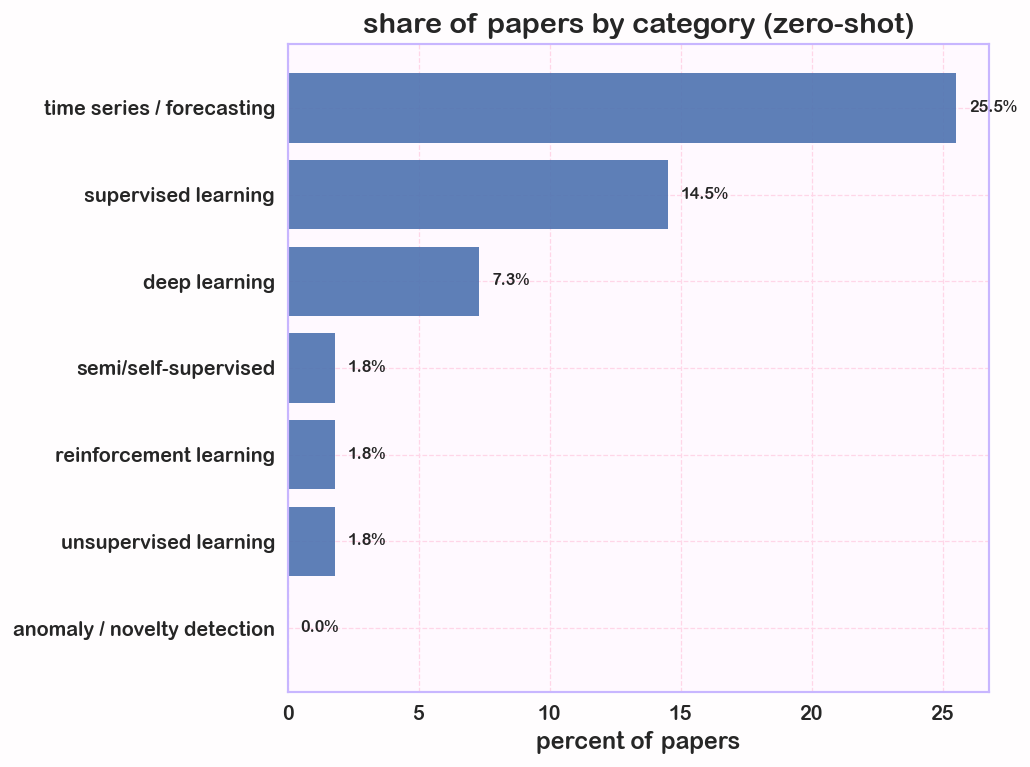

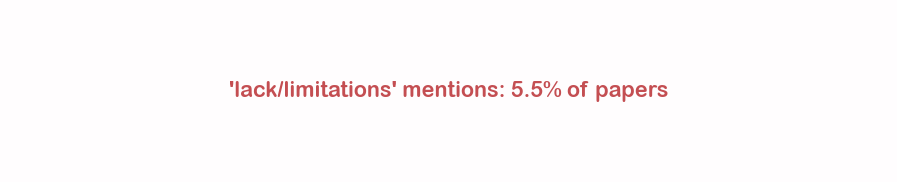


category share (zero-shot):


,category,n_papers,percent,desc
4,time series / forecasting,14,25.5,"temporal forecasting, time-series models, arim..."
1,supervised learning,8,14.5,classification or regression with labeled data
5,deep learning,4,7.3,"neural networks such as cnn, rnn, transformers"
0,unsupervised learning,1,1.8,"clustering, dimensionality reduction, anomaly ..."
2,reinforcement learning,1,1.8,"agents learning actions via rewards, rl, q-lea..."
3,semi/self-supervised,1,1.8,"semi-supervised, self-supervised, contrastive ..."
6,anomaly / novelty detection,0,0.0,detecting anomalies or outliers or rare events


 • 26% of papers dealt with time series / forecasting.
 • 14% of papers dealt with supervised learning.
 • 7.3% of papers dealt with deep learning.
 • 1.8% of papers dealt with unsupervised learning.
 • 1.8% of papers dealt with reinforcement learning.


In [13]:
# -----------------------------------------------------------------------------
# run in-place
# -----------------------------------------------------------------------------

if __name__ == "__main__":
    # log environment to stdout for traceability.
    _log_env()

    print("starting analysis...")
    runner = Runner(
        input_csv=INPUT_CSV,
        out_dir=OUT_DIR,
        threshold=THRESHOLD,
        device=DEVICE,
        batch_size=BATCH_SIZE,
        max_chars=MAX_CHARS,
    )
    summary = runner.run()
    # fixme: handle export of `summary["category_share"]` to csv if needed.

**Limitations**
- Export field names vary by source; mapping may need edits.
- Author disambiguation not performed (homonyms, initials).
- Citation counts are source-specific and time-sensitive.
- Topic extraction uses simple TF-IDF; consider LDA/BERTopic.

**Future Work**
- Author name disambiguation and ORCID matching.
- Louvain/Leiden clustering and community labeling.
- Temporal keyword bursts (Kleinberg) and trend analysis.
- Field-normalized citation indicators.
